**ECONOMETRIA ESPACIAL E TEMPORAL**

**Mestrado em Ciência de Dados para Ciências Sociais**

***Homework Assignment 2*** 

---

- **Grupo 6**: 
Lúcio Serôdio, 123991
|| Magda Matias, 50091
|| Rafael Santos, 118336


---

O trabalho divide-se pela seguinte estrutura:

1. Introdução
2. Importação de Bibliotecas
3. Definição dos Diretórios do Trabalho
4. Carregamento de Dados
5. Análise Exploratória Estatística da Variáveis Úteis ao Estudo (dependente e independentes)
6. Matriz e Pesos de Vizinhança
7. Dependência Espacial
8. Modelos Econométricos Espaciais
9. Conclusão Final
10. Referencial Teórico

---

# 1. Introdução





#### 1.1. Introdução téorica ao trabalho

Este estudo analisa os fatores que explicam a variação espacial do preço mediano de venda por m² nas freguesias do Algarve em 2021, uma região marcada por forte pressão imobiliária e contrastes territoriais. Através de técnicas de econometria espacial, como os modelos OLS, SAR e SDM, investiga-se de que forma as rendas médias e a tipologia T2 influenciam os preços, localmente e entre freguesias vizinhas. A incorporação da dimensão espacial é fundamental, pois permite captar heterogeneidades territoriais, dependência espacial e spillovers, oferecendo uma leitura mais rigorosa e realista das dinâmicas habitacionais no contexto algarvio.

#### 1.2. Segue-se uma breve caracterização das variáveis e objetivos do trabalho

**Indicadores:**

1- "Valor mediano das vendas por m2 de alojamentos familiares (Metodologia 2022 - €) por Localização geográfica (NUTS - 2024) e Categoria do alojamento familiar; Anual": será identificado como __df_vendas__;

2- "Valor médio mensal das rendas dos alojamentos familiares clássicos arrendados (€) por Localização geográfica à data dos Censos (2021) (NUTS - 2013); Decenal"**: será identificado como __df_rendas__;

3 - "Valor mediano das vendas por m2 de alojamentos familiares por Localização geográfica (NUTS - 2013) e Tipologia do fogo; Anual"** : será identificado como __df_vendas_tipo__ ;

---

**Pergunta de Investigação:**

Quais fatores explicam a variação espacial do preço mediano de venda por m² nas freguesias do Algarve em 2021, e de que forma a tipologia habitacional e os valores médios das rendas contribuem para essa heterogeneidade territorial?

# 2. Importação de Bibliotecas

In [1]:
import os
import sys
import importlib
from pathlib import Path

import pandas as pd
import geopandas as gpd
import geopandas as gpd

import numpy as np

## Matrizes vizinhança
import scipy
import seaborn as sns
import mapclassify as mc
import libpysal as lps
from pysal.lib import weights
from shapely.geometry import Point



import matplotlib.pyplot as plt 
import contextily as cx

from matplotlib.colors import ListedColormap

# Autocorrelações
from esda.moran import Moran
from esda.moran import Moran_Local
from splot.esda import moran_scatterplot
from splot.esda import lisa_cluster

# modelos
from spreg import OLS
import statsmodels.api as sm
from libpysal.weights import Rook
from spreg import diagnostics_sp as dsp
from libpysal.weights import lag_spatial
from scipy.stats import chi2

In [2]:
gpd.options.io_engine = "pyogrio"
os.environ["PYOGRIO_USE_ARROW"] = "1"

from pyogrio import list_layers

# 3. Definição dos diretórios de trabalho

In [3]:
from pathlib import Path

# Find the project root (assuming marker-based or script-relative path)
def find_project_root(marker="README.md"):
    current_dir = Path.cwd()
    while current_dir != current_dir.parent:  # Traverse up until root
        if (current_dir / marker).exists():
            return current_dir
        current_dir = current_dir.parent
    raise FileNotFoundError(f"Marker '{marker}' not found in any parent directory.")

project_root = find_project_root()
sys.path.append(str(project_root)) 

# Or use a relative path: project_root = Path(__file__).resolve().parent.parent
os.chdir(project_root)
print(f"Working directory set to: {project_root}")

Working directory set to: c:\Users\rafae\OneDrive\Ambiente de Trabalho\Trabalhos_Grupo6\Trabalhos_Grupo6


In [4]:
module_path = os.path.abspath(os.path.join(r'.\src'))
if module_path not in sys.path:
    sys.path.append(module_path)

module_path

import utils.utils_ete2425

In [5]:
# Verificar acesso ao utils
import sys
sys.path.append('src/utils/utils_ete2425.py')

# 4. Carregamento de Dados

### Importação dados CAOP

In [6]:
shape_CAOP_FREGUESIAS = gpd.read_file(r'.\data\input' + r'\CAOP2023\Continente_CAOP2023.gpkg', layer = 'Cont_Freg_CAOP2023')
shape_CAOP_LIMITES = gpd.read_file(r'.\data\input' + r'\CAOP2023\Continente_CAOP2023.gpkg', layer = 'Cont_Troco_CAOP2023')

In [7]:
shape_CAOP_FREGUESIAS.columns

Index(['DICOFRE', 'Freguesia', 'Municipio', 'Distrito', 'Area_ha',
       'Des_Simpli', 'geometry'],
      dtype='object')

In [8]:
shape_CAOP_FREGUESIAS.head(3)

,DICOFRE,Freguesia,Municipio,Distrito,Area_ha,Des_Simpli,geometry
0,010103,Aguada de Cima,Águeda,Aveiro,2839.31,Aguada de Cima,"MULTIPOLYGON (((-22457.151 97217.803, -22423.8..."
1,010109,Fermentelos,Águeda,Aveiro,858.20,Fermentelos,"MULTIPOLYGON (((-31260.894 100010.838, -31262...."
2,010112,Macinhata do Vouga,Águeda,Aveiro,3195.44,Macinhata do Vouga,"MULTIPOLYGON (((-20410.354 112211.523, -20409...."


In [9]:
shape_CAOP_LIMITES.head(3)

,ID_TROCO,ENT_DIREIT,ENT_ESQUER,ICC,BST,MOL,COMP_m,geometry
0,20,Sagres,Oceano Atlântico,PT,Definido,LIMITE E LINHA DE COSTA,48.33,"MULTILINESTRING ((-68795.79 -293292.348, -6879..."
1,327,Bordeira,Oceano Atlântico,PT,Definido,LIMITE E LINHA DE COSTA,20.16,"MULTILINESTRING ((-69134.893 -274756.276, -691..."
2,424,Rogil,Oceano Atlântico,PT,Definido,LIMITE E LINHA DE COSTA,24.14,"MULTILINESTRING ((-60040.627 -250392.798, -600..."


### Restringir áreas e limites do CAOP à região do Algarve (região de Análise)

Decidimos escolher a região do Algarve como área de estudo devido à sua relevância no mercado imobiliário português, caracterizando-se por ter uma forte procura turística e residencial, quer a nível nacional, quer internacional. A região apresenta variações significativas nos preços da habitação, influenciadas por fatores como a proximidade ao mar, acessibilidade, infraestruturas e presença de investidores estrangeiros. Além disso, a disponibilidade de dados oficiais detalhados permite uma análise espacial robusta, facilitando a identificação de padrões de dependência espacial.

In [10]:
#Areas
Algarve_CAOP_FREGUESIAS =  shape_CAOP_FREGUESIAS[shape_CAOP_FREGUESIAS['DICOFRE'].str.startswith('08')]

In [11]:
# Projeção geográfica do sistema de referenciação fornecido na BGRI2021 (EPSG:3763) para o sistema de referenciação
# utilizado na biblioteca "contextily" (EPSG:3857)
# A biblioteca "contextily" permite a sobreposição de mapas base (imagens de satélite, mapas de ruas, etc) sobre
# os nossos mapas / representações geométricas das nossas unidades de análise

Algarve_CAOP_FREGUESIAS_reproject = Algarve_CAOP_FREGUESIAS.to_crs(epsg=3857)

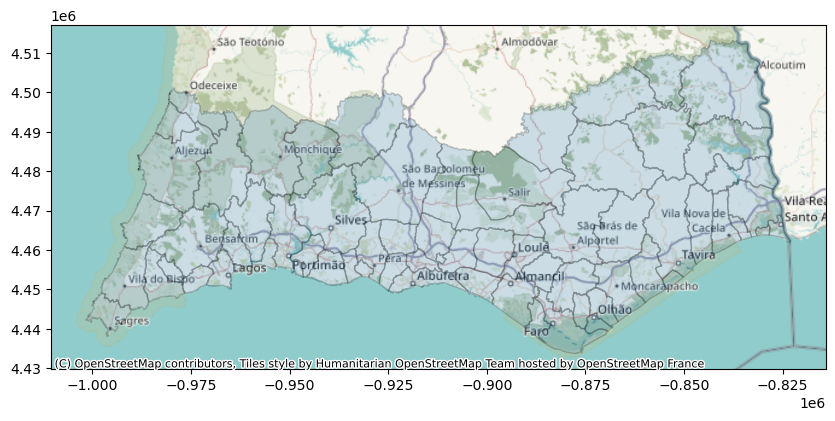

In [12]:
# Adição de um mapa de fundo ao nosso mapa de subsecções estatísticas do Algarve
# Neste caso, associamos um mapa obtido no serviço OpenStreetMaps https://www.openstreetmap.org/

ax = Algarve_CAOP_FREGUESIAS_reproject.plot(figsize=(10, 10), alpha=0.2, edgecolor="k")
cx.add_basemap(ax)

In [17]:
Algarve_CAOP_FREGUESIAS.head(3)

,DICOFRE,Freguesia,Municipio,Distrito,Area_ha,Des_Simpli,geometry
1226,080102,Guia,Albufeira,Faro,2496.60,Guia,"MULTIPOLYGON (((-12970.384 -280121.571, -12970..."
1227,080103,Paderne,Albufeira,Faro,5256.17,Paderne,"MULTIPOLYGON (((-2072.376 -275271.238, -2066.6..."
1228,080104,Ferreiras,Albufeira,Faro,2195.96,Ferreiras,"MULTIPOLYGON (((-4475.16 -280601.518, -4479.37..."


### Importação dados INE - Censos em geopackage do Algarve

In [13]:
print(list_layers('data\BGRI21_150\BGRI21_150.gpkg'))

[['BGRI21_150' 'MultiPolygon']]


<>:1: SyntaxWarning: invalid escape sequence '\B'
<>:1: SyntaxWarning: invalid escape sequence '\B'
C:\Users\rafae\AppData\Local\Temp\ipykernel_21952\1814613475.py:1: SyntaxWarning: invalid escape sequence '\B'
  print(list_layers('data\BGRI21_150\BGRI21_150.gpkg'))


### Importação de dados INE - Censos e estatísticas 2021


Indicadores:
- **Variável dependente (Y)**: Preço mediano das vendas por m²
Representa a valorização do mercado habitacional e permite identificar potenciais padrões espaciais na formação de preços no território.

- **Variável explicativa (X1)**: Preço mediano das vendas por tipologia
Capta variações associadas ao tipo de habitação, permitindo avaliar em que medida a tipologia influencia o valor unitário da habitação (€/m²), de forma diferenciada no espaço.

- **Variável explicativa (X2)**: Valor médio mensal das rendas
Permite analisar a relação entre os preços de venda e o mercado de arrendamento, avaliando se as zonas com preços de compra mais elevados também apresentam rendas médias mais altas — sugerindo possíveis efeitos de complementaridade ou substituição espacial entre os dois mercados.

In [14]:
# Carregar os dados
# Valor médio mensal das rendas (Censos 2021)
df_rendas = pd.read_excel('data/algarve/valor_medio_mensal_rendas_FREGUESIAS_2021.xls', dtype={'CODIGO': str})

# Valor mediano das vendas por m² (2021 a 2023)
df_vendas = pd.read_excel('data/algarve/valor_mediano_vendas_m2_FREGUESIAS_2021_a_2023.xls', dtype={'CODIGO': str})

# Valor mediano das vendas por tipologia (2021 e 2022)
df_vendas_tipo = pd.read_excel('data/algarve/valor_mediano_vendas_por_tipologia_FREGUESIAS_2021_a_2022.xls', dtype={'CODIGO': str})

In [15]:
df_rendas.head(1)

,Localizacao,CODIGO,2021_rendas
0,Albufeira e Olhos de Água,080106,450.94


In [16]:
df_vendas.head(1)

,Localizacao,Codigo_identificador,CODIGO,2023_Total,2023_Novos,2023_Existentes,2022_Total,2022_Novos,2022_Existentes,2021_Total,2021_Novos,2021_Existentes
0,Albufeira e Olhos de Água,150080106,080106,2821.0,3044.0,2785.0,2576.0,2870.0,2500.0,2233.0,2549.0,2144.0


In [17]:
df_vendas_tipo.head(1)

,Localização geográfica (NUTS - 2013) (1),codigo identificador,CODIGO,2022_Total,2022_T0 ou T1,2022_T2,2022_T3,2022_T4 ou mais,2021_Total,2021_T0 ou T1,2021_T2,2021_T3,2021_T4 ou mais
0,Albufeira e Olhos de Água,150080106,080106,2576.0,2544.0,2551.0,2737.0,2811.0,2233.0,2278.0,2144.0,2092.0,2523.0


## Combinar os dados do INE com os dados geométricos

Pretende-se coincidir o campo __"DICOFRE"__ da base de dados da CAOP com o campo __"CODIGO"__ das folhas de cálculo dos dados do INE.

In [18]:
#Visualizar tipo dados do CAOP
Algarve_CAOP_FREGUESIAS['DICOFRE']=Algarve_CAOP_FREGUESIAS['DICOFRE'].astype(str)

Algarve_CAOP_FREGUESIAS.dtypes

c:\Users\rafae\anaconda3\envs\env_ETE_2425\Lib\site-packages\geopandas\geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


DICOFRE         object
Freguesia       object
Municipio       object
Distrito        object
Area_ha        float64
Des_Simpli      object
geometry      geometry
dtype: object

#### **Variável dependente/alvo (Y) - Indicador: preço mediano das vendas por m2 (2021)**

In [19]:
#Visualizar tipo dados das vendas
df_vendas['CODIGO']=df_vendas['CODIGO'].astype(str)

df_vendas.dtypes

Localizacao              object
Codigo_identificador      int64
CODIGO                   object
2023_Total              float64
2023_Novos              float64
2023_Existentes         float64
2022_Total              float64
2022_Novos              float64
2022_Existentes         float64
2021_Total              float64
2021_Novos              float64
2021_Existentes         float64
dtype: object

In [20]:
#Merge de dados
gdf_CAOP_Algarve_precoVenda=Algarve_CAOP_FREGUESIAS_reproject.merge(df_vendas, left_on = 'DICOFRE', right_on = 'CODIGO')

# Preencher valores NaN a zeros para surgir no mapa
gdf_CAOP_Algarve_precoVenda.fillna(0, inplace=True)


In [21]:
gdf_CAOP_Algarve_precoVenda[['Localizacao', 'Freguesia', 'DICOFRE', '2021_Total']].head(3)

,Localizacao,Freguesia,DICOFRE,2021_Total
0,Guia,Guia,080102,2334.0
1,Paderne,Paderne,080103,1510.0
2,Ferreiras,Ferreiras,080104,1700.0


#### **Variável independente/explicativa 1 - Indicador: valor medianos das rendas mensais (2021)**

In [22]:
#Visualizar tipo de dados das rendas
df_rendas['CODIGO']=df_rendas['CODIGO'].astype(str)

df_rendas.dtypes

Localizacao     object
CODIGO          object
2021_rendas    float64
dtype: object

In [23]:
#Merge de dados
gdf_CAOP_Algarve_rendas=Algarve_CAOP_FREGUESIAS_reproject.merge(df_rendas, left_on = 'DICOFRE', right_on = 'CODIGO')

# Preencher valores NaN a zeros para surgir no mapa
gdf_CAOP_Algarve_rendas.fillna(0, inplace=True)

In [24]:
gdf_CAOP_Algarve_rendas[['Localizacao', 'Freguesia', 'DICOFRE', '2021_rendas']].head(3)

,Localizacao,Freguesia,DICOFRE,2021_rendas
0,Guia,Guia,080102,431.18
1,Paderne,Paderne,080103,356.94
2,Ferreiras,Ferreiras,080104,407.08


#### **Variável independente/explicativa 2 - Indicador: preço mediano por tipologia (2021)**

In [25]:
#Visualizar tipo de dados do valor médio de vendas por tipologia
df_vendas_tipo['CODIGO']=df_vendas_tipo['CODIGO'].astype(str)

df_vendas_tipo.dtypes

Localização geográfica (NUTS - 2013) (1)     object
codigo identificador                          int64
CODIGO                                       object
2022_Total                                  float64
2022_T0 ou T1                               float64
2022_T2                                     float64
2022_T3                                     float64
2022_T4 ou mais                             float64
2021_Total                                  float64
2021_T0 ou T1                               float64
2021_T2                                     float64
2021_T3                                     float64
2021_T4 ou mais                             float64
dtype: object

In [26]:
#Merge de dados
gdf_CAOP_Algarve_tipologia=Algarve_CAOP_FREGUESIAS_reproject.merge(df_vendas_tipo, left_on = 'DICOFRE', right_on = 'CODIGO')

# Preencher valores NaN a zeros para surgir no mapa
gdf_CAOP_Algarve_tipologia.fillna(0, inplace=True)

gdf_CAOP_Algarve_tipologia.columns

#Mostrar linhas
gdf_CAOP_Algarve_tipologia[['Localização geográfica (NUTS - 2013) (1)',
                             '2021_Total', '2021_T0 ou T1', '2021_T2', '2021_T3', '2021_T4 ou mais']].head(3)

,Localização geográfica (NUTS - 2013) (1),2021_Total,2021_T0 ou T1,2021_T2,2021_T3,2021_T4 ou mais
0,Guia,2334.0,2123.0,2309.0,2686.0,0.0
1,Paderne,1510.0,0.0,0.0,0.0,0.0
2,Ferreiras,1700.0,0.0,0.0,0.0,0.0


# 5. Análise Exploratória Estatística e Espacial das Variáveis Úteis ao Estudo (alvo e explicativas)

### Preço mediano de vendas por m2 (2021) (variável dependente)

In [27]:
gdf_CAOP_Algarve_precoVenda["2021_Total"].describe()

count      67.000000
mean     1407.402985
std       924.755317
min         0.000000
25%       772.500000
50%      1699.000000
75%      2048.500000
max      3818.000000
Name: 2021_Total, dtype: float64

In [28]:
gdf_CAOP_Algarve_precoVenda['Ln_2021_Total'] = np.log1p(gdf_CAOP_Algarve_precoVenda['2021_Total'])

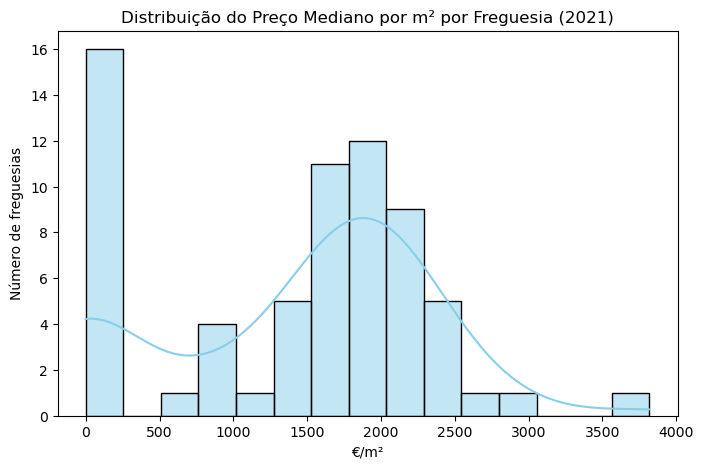

In [29]:
# histograma
plt.figure(figsize=(8, 5))
sns.histplot(
    data=gdf_CAOP_Algarve_precoVenda,
    x="2021_Total",
    bins=15,
    kde=True,  # ativa a curva de densidade
    color='skyblue',
    edgecolor='black'
)

plt.title("Distribuição do Preço Mediano por m² por Freguesia (2021)")
plt.xlabel("€/m²")
plt.ylabel("Número de freguesias")
plt.show()

**Interpretação:** O preço médio das vendas por m² no Algarve em 2021 foi de 1.407 €/m², com valores a oscilar entre 0 €/m² e 3.818 €/m², refletindo uma forte discrepância entre freguesias. A mediana de 1.699 €/m² indica que metade das freguesias tem preços inferiores a este valor, enquanto o desvio padrão elevado (924 €/m²) sugere uma grande variação entre zonas. Além disso, 25% das freguesias apresentam valores abaixo dos 772 €/m², reforçando a diferença acentuada entre o litoral e o interior. Importante relembrar ainda que existe muitas zonas com valores ausentes.

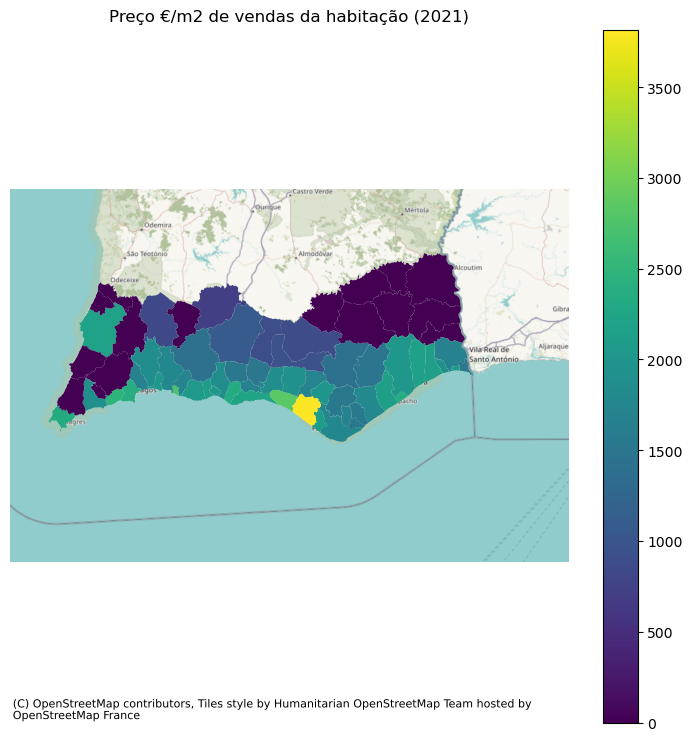

In [30]:
figura, ax = plt.subplots(1, figsize=(9,9))

gdf_CAOP_Algarve_precoVenda.plot(ax=ax, column='2021_Total', legend=True)

cx.add_basemap(ax)

ax.set_axis_off()
ax.set_title('Preço €/m2 de vendas da habitação (2021)')
plt.axis('equal')
plt.show()

**Interpretação:**
Os valores mais elevados concentram-se no litoral central e barlavento algarvio, destacando-se as freguesias de Quarteira e Almancil, onde os preços ultrapassam os 2.800 €/m². No interior, predominam preços mais baixos (inderiores a 1100 €/m²), com <u>várias freguesias a roxo escuro, indicando ausência de valores registados</u>. Este padrão evidencia uma forte diferenciação geográfica, com valores significativamente mais elevados nas zonas turísticas do litoral, contrastando com a menor dinâmica do mercado no interior algarvio.

### Preço mediano das rendas (2021) (variável Independente 1)

In [31]:
gdf_CAOP_Algarve_rendas["2021_rendas"].describe()

count     67.000000
mean     329.211940
std       91.264562
min        0.000000
25%      284.270000
50%      342.320000
75%      388.545000
max      507.410000
Name: 2021_rendas, dtype: float64

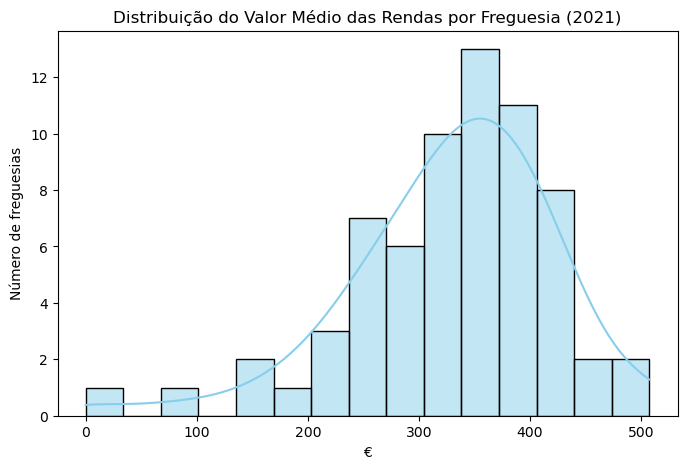

In [32]:
plt.figure(figsize=(8, 5))
sns.histplot(
    data=gdf_CAOP_Algarve_rendas,
    x="2021_rendas",
    bins=15,
    kde=True,  
    color='skyblue',
    edgecolor='black'
)

plt.title("Distribuição do Valor Médio das Rendas por Freguesia (2021)")
plt.xlabel("€")
plt.ylabel("Número de freguesias")
plt.show()

**Interpretação:** O valor médio das rendas no Algarve em 2021 foi de 329 €/mês, com valores a variar entre 0 € e 507 €/mês, refletindo diferenças significativas entre freguesias. A mediana de 342 € indica que metade das freguesias apresenta rendas inferiores a este valor, enquanto um quarto das freguesias tem rendas abaixo de 284 €, sugerindo zonas com valores bastante acessíveis. O desvio padrão de 91 € demonstra alguma dispersão nos valores, mas menor do que nos preços de venda, indicando uma menor desigualdade no mercado de arrendamento.

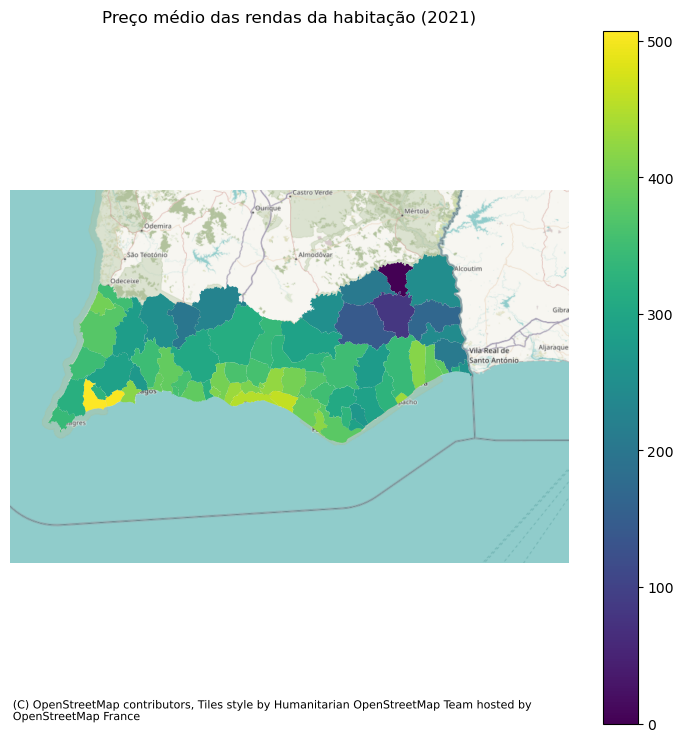

In [33]:
figura, ax = plt.subplots(1, figsize=(9,9))

gdf_CAOP_Algarve_rendas.plot(ax=ax, column='2021_rendas', legend=True)

cx.add_basemap(ax)

ax.set_axis_off()
ax.set_title('Preço médio das rendas da habitação (2021)')
plt.axis('equal')
plt.show()

**Interpretação:** Os valores das rendas em 2021 são mais elevados ao longo da costa algarvia, destacando-se, sobretudo as zonas de Lagos, Albufeira, Quarteira e Vila do Bispo, onde ultrapassam os 450 €/mês. No interior, predominam valores mais baixos (maioria inferiores a 300 €/mês), nomeadamente em Alcoutim e Monchique. Algumas freguesias surgem a roxo escuro, indicando provável ausência de dados ou escassez de arrendamento registado. Existe assim um padrão geográfico que sugere uma forte correlação entre as rendas e a valorização turística, concentrando os preços mais elevados no litoral. Tal como no mercado de compra, verifica-se uma grande discrepância entre o litoral e o interior algarvio.

### Preço mediano por tipologia da habitação (2021) (variável Independente 2)

In [34]:
# Análise estatistica superficial
gdf_CAOP_Algarve_tipologia[["2021_T0 ou T1", "2021_T2", "2021_T3", "2021_T4 ou mais"]].describe()

,2021_T0 ou T1,2021_T2,2021_T3,2021_T4 ou mais
count,67.000000,67.000000,67.000000,67.000000
mean,657.537313,881.761194,823.597015,583.164179
std,1034.224733,1003.416257,1044.183980,1129.475134
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,1847.500000,1777.000000,1777.500000,702.000000
max,3069.000000,3374.000000,3713.000000,5645.000000


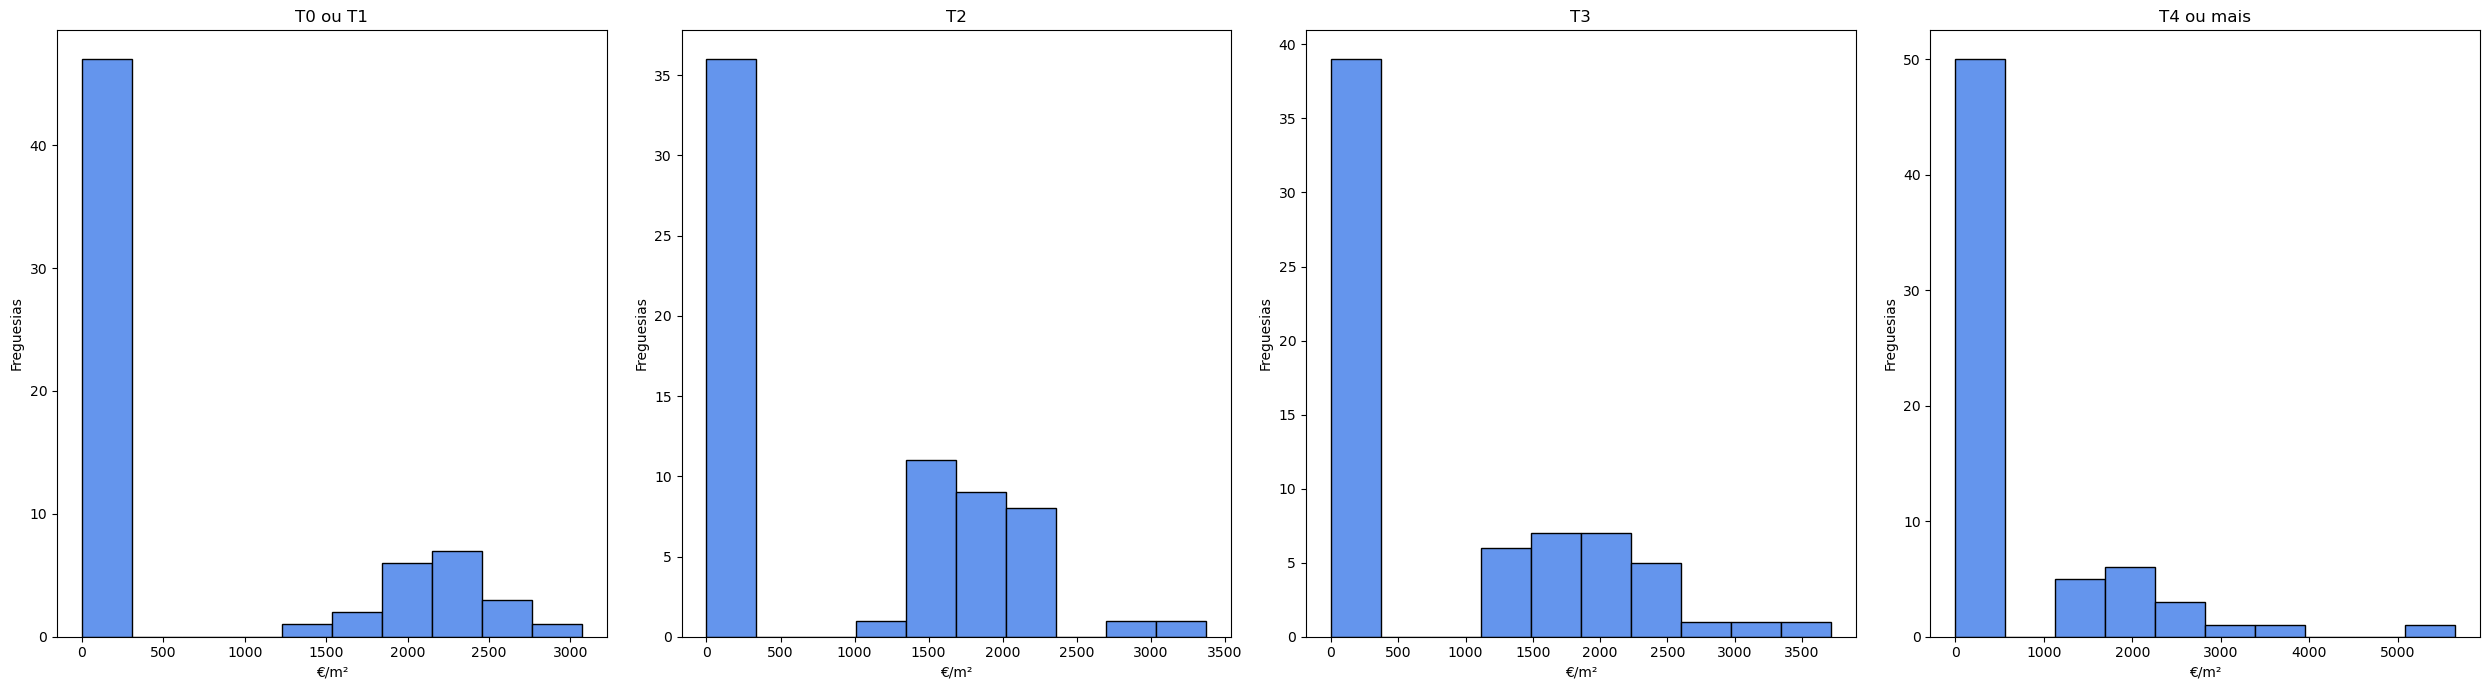

In [35]:
# histogramas
tipo = ["2021_T0 ou T1", "2021_T2", "2021_T3", "2021_T4 ou mais"]
titulos = ["T0 ou T1", "T2", "T3", "T4 ou mais"]

fig, axes = plt.subplots(1, 4, figsize=(25, 7))  

for i, col in enumerate(tipo):
    gdf_CAOP_Algarve_tipologia[col].plot.hist(
        ax=axes[i],
        bins=10,
        color='cornflowerblue',
        edgecolor='black'
    )
    axes[i].set_title(f"{titulos[i]}")
    axes[i].set_xlabel("€/m²")
    axes[i].set_ylabel("Freguesias")
    axes[i].grid(False)

plt.tight_layout()
plt.show()

**Interpretação:** Os valores medianos de venda por m² em 2021 revelam uma elevada variação entre tipologias e freguesias. Os T2 e T3 são as mais representativas, com valores médios de 882 €/m² e 824 €/m², respetivamente, e distribuições concentrdas entre os 1.500€ e os 2.500€/m². Já os T0/T1 e T4 ou + apresentam maior dispersão e valores máximos mais elevados, atingindo mesmo os 5.645 €/m² no caso dos T4+, o que pode indicar segmentos de mercado menos homogéneos, como habitação de luxo ou situações pontuais. A elevada proporção de freguesias com valores nulos (mediana = 0 €) revela a ausência de transações em várias áreas, evidenciando a distribuição desigual destas tipologias no território.

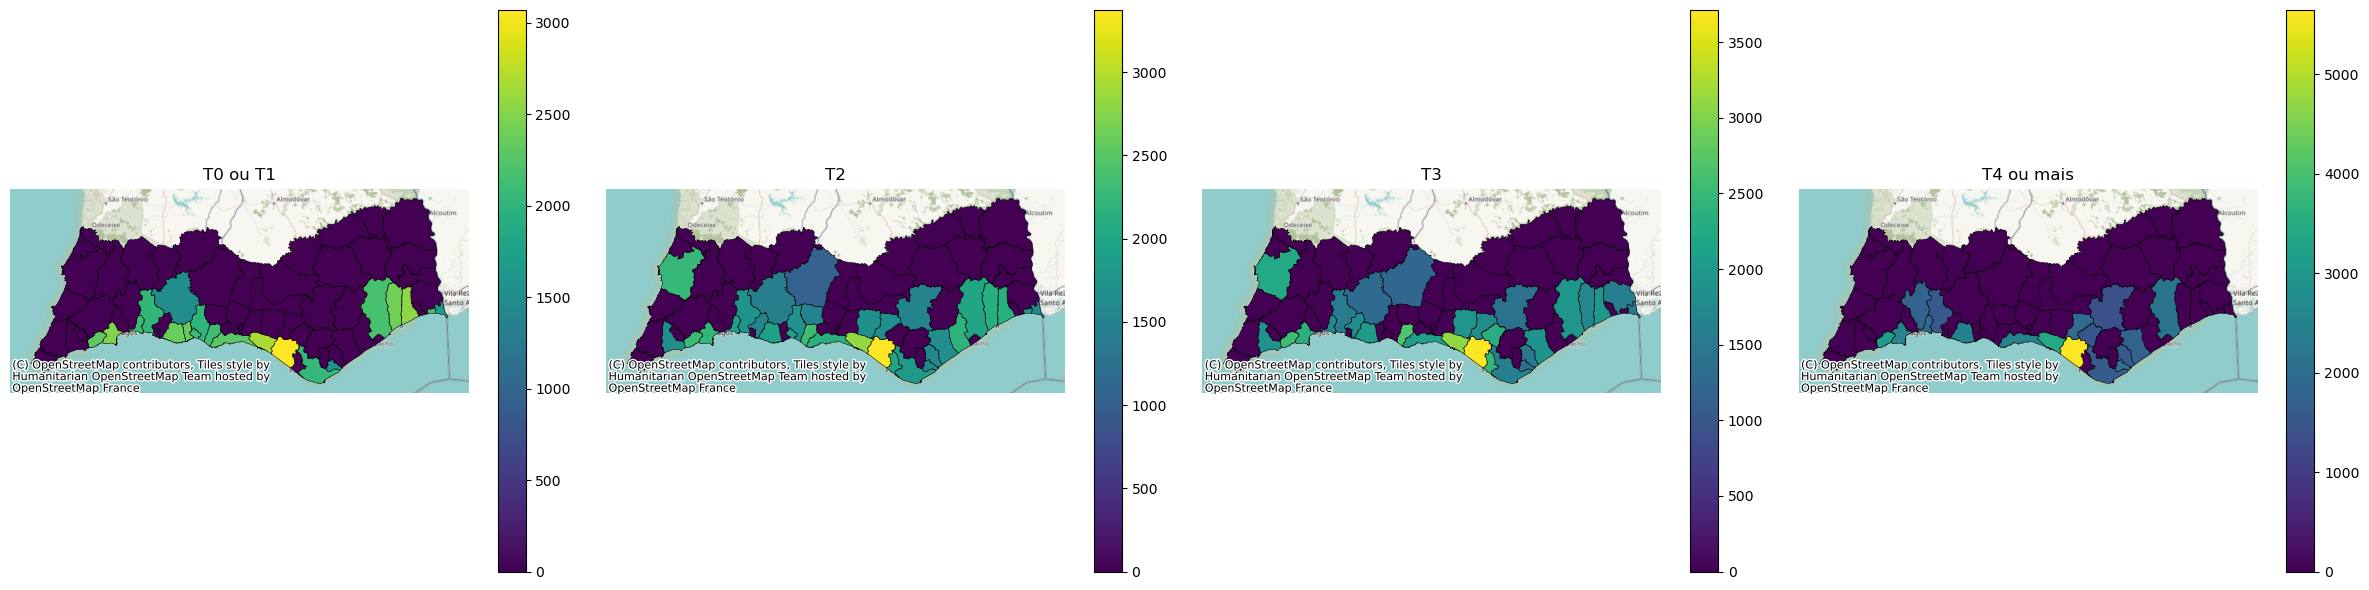

In [36]:
fig, axes = plt.subplots(1, 4, figsize=(24, 6))  # 1 linha, 4 colunas

for i, col in enumerate(tipo):
    gdf_CAOP_Algarve_tipologia.plot(
        ax=axes[i],
        column=col,
        cmap='viridis',
        legend=True,
        edgecolor='black',
        linewidth=0.4
    )
    cx.add_basemap(axes[i], crs=gdf_CAOP_Algarve_tipologia.crs)
    axes[i].set_title(f"{titulos[i]}", fontsize=12)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

**Interpretação:** Em termos de distribuição espacial é evidente padrões territoriais distintos. As tipologias T2 e T3 apresentam uma cobertura territorial mais ampla, com valores mais elevados concentrados nas zonas litorais e urbanas, nomeadamente nos municípios de Loulé, Albufeira e Lagos. Por outro lado, os T0/T1 e T4 ou + surgem de forma mais dispersa, com várias freguesias sem registo de transações. Os valores mais altos de T4+ localizam-se sobretudo em áreas turísticas, refletindo o peso de habitações de maior dimensão e valor no mercado de luxo.

# 6. Matriz e pesos de vizinhança

Uma vez que temos dados omissos (16 freguesias sem dados de preço mediano de vendas por m2), vamos aplicar a imputação média dos vizinhos.
<u>Nota:</u> os dados omissos são os que apresentam valores a zero.

No contexto do Algarve, o **uso do Rook** é mais adequado porque considera como vizinhas apenas as freguesias que partilham uma fronteira, refletindo melhor a influência espacial direta nos preços da habitação. O critério Queen incluiria freguesias que apenas se tocam nos vértices, podendo criar conexões menos realistas entre zonas sem interação significativa.

In [37]:
w_rook_gdf_CAOP_Algarve_precoVenda = weights.contiguity.Rook.from_dataframe(gdf_CAOP_Algarve_precoVenda, use_index=True)

# normalização dos pesos da matriz
w_rook_gdf_CAOP_Algarve_precoVenda.transform = 'r'

Como a dataframe __gpd_CAOP_Algarve_precoVenda__ não tem _missing values_, ou seja, valores vazios, os pesos da matriz vizinhança vão ser atribuidos aos valores zeros, que efectivamente significam que não há dados dos preços medianos de vendas naquela(s) freguesia(s).

In [38]:

# Função para aplicar pesos aos valores zero
def apply_weights_to_zero_values(gdf, weights, colname):
    zero_mask = gdf[colname] == 0
    for index, row in gdf[zero_mask].iterrows():
        neighbors = list(weights.neighbors[index])  # Obter os vizinhos como lista
        if neighbors:
            values = gdf.loc[neighbors, colname].values
            gdf.at[index, colname] = values.mean() if len(values) > 0 else 0
    return gdf

gdf_CAOP_Algarve_precoVenda['2021_imputacao'] = gdf_CAOP_Algarve_precoVenda['2021_Total']
gdf_CAOP_Algarve_precoVenda = apply_weights_to_zero_values(
    gdf_CAOP_Algarve_precoVenda, w_rook_gdf_CAOP_Algarve_precoVenda, colname='2021_imputacao'
)

gdf_CAOP_Algarve_precoVenda[['2021_imputacao', '2021_Total']]

,2021_imputacao,2021_Total
0,2334.000,2334.0
1,1510.000,1510.0
2,1700.000,1700.0
3,2233.000,2233.0
4,0.000,0.0
...,...,...
62,2333.000,2333.0
63,1573.975,0.0
64,2136.000,2136.0
65,1533.000,1533.0


#### Comparar resultados após imputação de pesos

In [39]:
gdf_CAOP_Algarve_precoVenda[['2021_Total', '2021_imputacao']].describe().round(1)

,2021_Total,2021_imputacao
count,67.0,67.0
mean,1407.4,1623.6
std,924.8,688.5
min,0.0,0.0
25%,772.5,1356.2
50%,1699.0,1700.0
75%,2048.5,2048.5
max,3818.0,3818.0


- A média aumentou de 1407,40 para 1623,60;
- O desvio-padrão diminuiu de 924,80 para 688,50;
- O primeiro quartil alterou de 772,50 para 1356,20

In [40]:
# Registam-se duas freguesias com valores de 0 €/m², que serão mantidas na análise por refletirem a realidade do mercado imobiliário na região, indicando áreas com baixa ou inexistente atividade de transações.
print(gdf_CAOP_Algarve_precoVenda[gdf_CAOP_Algarve_precoVenda['2021_imputacao'] == 0][['DICOFRE', 'Freguesia']])


  DICOFRE     Freguesia
4  080202         Giões
5  080203  Martim Longo


In [41]:
classif_quart=mc.Quantiles(gdf_CAOP_Algarve_precoVenda['2021_imputacao'], k=5)
classif_quart

Quantiles

     Interval        Count
--------------------------
[   0.00, 1003.07] |    14
(1003.07, 1530.60] |    13
(1530.60, 1856.40] |    13
(1856.40, 2114.40] |    13
(2114.40, 3818.00] |    14

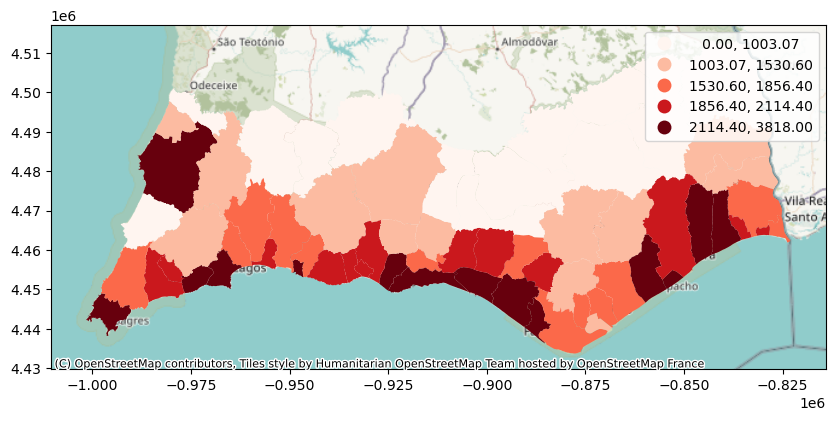

In [42]:
# Padrões geográficos
figura, ax = plt.subplots(figsize = (10,10) )
ax.set_aspect('equal')

gdf_CAOP_Algarve_precoVenda.plot(ax=ax,zorder=1,
                      # marker="s",
                      column='2021_imputacao', #'2021_Total' para ver a original
                      scheme='Quantiles', 
                      # k=7, 
                      cmap=plt.cm.Reds, 
                      linewidth=0,
                      legend=True)

cx.add_basemap(ax)

**Interpretação:** Observa-se uma clara diferenciação geográfica, onde as freguesias com valores mais elevados (tons mais escuros) se concentram no litoral, especialmente no centro e barlavento algarvio. Já as zonas com preços mais baixos (tons mais claros) situam-se predominantemente no interior, indicando uma menor valorização do mercado imobiliário. Estes padrões sugerem uma forte influência do turismo e proximidade ao mar na valorização dos imóveis.

# 7. Dependência Espacial

A dependência espacial refere-se à ideia de que os valores observados numa dada região podem estar influenciados pelos valores das regiões vizinhas. Em contexto económico e geográfico, isto significa que fenómenos como preços, rendas ou tipologias habitacionais não estão distribuídos aleatoriamente no espaço, mas sim tendem a agrupar-se ou espalhar-se de forma estruturada.

Para detetar e medir essa dependência, utilizam-se indicadores como o Índice de Moran e o LISA:

- O Índice de **Moran Global** quantifica a autocorrelação espacial global, indicando se há padrões de concentração (valores altos ou baixos agrupados) em todo o território analisado.

- O **LISA (Local Indicators of Spatial Association)** permite identificar clusters locais de dependência espacial, destacando freguesias onde os valores diferem ou se assemelham significativamente aos das vizinhas.

In [43]:
precoM2_lag = weights.lag_spatial(w_rook_gdf_CAOP_Algarve_precoVenda, gdf_CAOP_Algarve_precoVenda['2021_imputacao'] )
gdf_CAOP_Algarve_precoVenda["2021_imputacao_lag"] = precoM2_lag

In [44]:
# "Normalizar" (cálculo de z-scores) as variáveis (original imputada e desfasada)
gdf_CAOP_Algarve_precoVenda['2021_imputacao_std'] = (
    gdf_CAOP_Algarve_precoVenda['2021_imputacao'] - gdf_CAOP_Algarve_precoVenda['2021_imputacao'].mean()
) / gdf_CAOP_Algarve_precoVenda['2021_imputacao'].std()

gdf_CAOP_Algarve_precoVenda['2021_imputacao_lag_std'] = (
    gdf_CAOP_Algarve_precoVenda['2021_imputacao_lag'] - gdf_CAOP_Algarve_precoVenda['2021_imputacao_lag'].mean()
) / gdf_CAOP_Algarve_precoVenda['2021_imputacao_lag'].std()


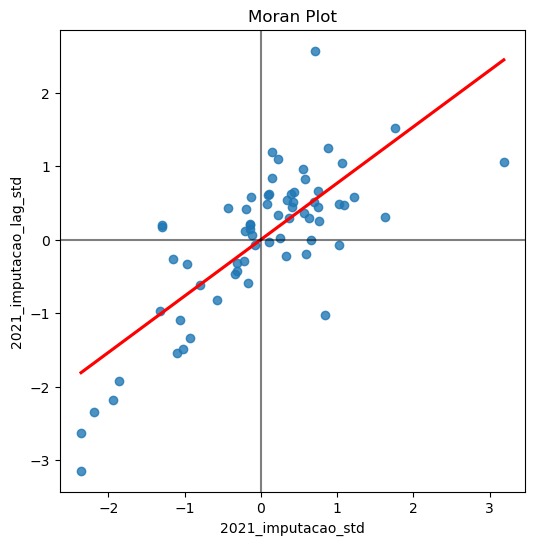

In [45]:
# Moran Plot
f, ax = plt.subplots(1, figsize=(6, 6))
sns.regplot(x='2021_imputacao_std', y='2021_imputacao_lag_std', 
                ci=None, data=gdf_CAOP_Algarve_precoVenda, line_kws={'color':'r'})
ax.axvline(0, c='k', alpha=0.5)
ax.axhline(0, c='k', alpha=0.5)
ax.set_title('Moran Plot')
plt.show()

**Interpretação:** O Moran Plot revela uma autocorrelação espacial positiva, indicando que freguesias com preços elevados tendem a estar próximas de outras também com valores altos, enquanto freguesias com preços mais baixos se agrupam entre si. A inclinação da reta de regressão sugere uma relação espacial moderada, com alguma dispersão dos pontos. Apesar da variabilidade, observa-se um padrão espacial onde os valores do mercado imobiliário não estão distribuídos aleatoriamente, mas sim influenciados pelos valores das freguesias vizinhas.

## Autocorrelação Espacial - Global - MORAN

In [46]:
# Calcular o indice de Moran
morans_I = Moran(gdf_CAOP_Algarve_precoVenda['2021_imputacao_std'], w_rook_gdf_CAOP_Algarve_precoVenda)

print(f"Índice de Moran: {morans_I.I:.4f}")
print(f"p-valor: {morans_I.p_sim:.4f}")
print(f"z-score: {morans_I.z_sim:.4f}")


Índice de Moran: 0.5167
p-valor: 0.0010
z-score: 6.4743


**Interpretação:** O Índice de Moran Global de 0.5167 indica uma autocorrelação espacial positiva moderada nos preços da habitação, ou seja, freguesias com preços elevados tendem a estar próximas de outras com valores altos, e o mesmo acontece com preços baixos. O p-valor de 0.0010 mostra que esta autocorrelação é estatisticamente significativa ao nível de 1%, confirmando que os preços não estão distribuídos aleatoriamente. O z-score de 6.5130 reforça essa evidência, indicando que o padrão espacial observado é altamente improvável de ter ocorrido por acaso.

### **Inferência de Moran**

- Partiremos das seguintes questões:

H0 = Não existe autocorrelação espacial significativa nos preços da habitação. Os valores estão distribuídos aleatoriamente no espaço.

H1 = Existe autocorrelação espacial significativa nos preços da habitação, indicando um padrão espacial estruturado.

In [60]:
# Teste de permutação para Moran
morans_I_perm = Moran(gdf_CAOP_Algarve_precoVenda['2021_imputacao_std'], 
                      w_rook_gdf_CAOP_Algarve_precoVenda, 
                      permutations=999)

print(f"Índice de Moran: {morans_I_perm.I:.4f}")
print(f"p-valor: {morans_I_perm.p_sim:.4f}") 
print(f"z-score: {morans_I_perm.z_sim:.4f}")  

Índice de Moran: 0.5167
p-valor: 0.0010
z-score: 6.3508


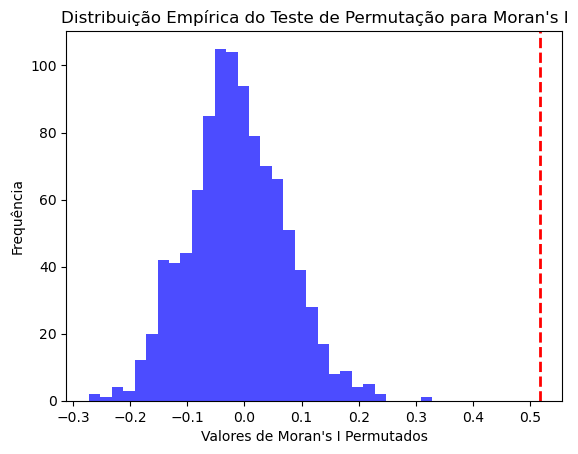

In [62]:
# Visualizar
plt.hist(morans_I_perm.sim, bins=30, alpha=0.7, color='blue')  # Distribuição empírica
plt.axvline(morans_I_perm.I, color='red', linestyle='dashed', linewidth=2)  # Valor observado
plt.title("Distribuição Empírica do Teste de Permutação para Moran's I")
plt.xlabel("Valores de Moran's I Permutados")
plt.ylabel("Frequência")
plt.show()

**Interpretação:** O teste de permutação confirma a existência de autocorrelação espacial positiva significativa nos preços de venda por m² no Algarve. O Moran’s I observado (0.5167) está muito acima da distribuição empírica gerada aleatoriamente, com um p-valor < 0.01, o que nos leva a rejeitar a hipótese nula (H0) de ausência de padrão espacial. Assim, aceitamos a hipótese alternativa (H1), concluindo que os preços da habitação não estão distribuídos aleatoriamente, mas seguem um padrão espacial significativo. Este resultado indica que freguesias com preços semelhantes tendem a agrupar-se no território, refletindo a presença de heterogeneidade espacial e sugerindo possíveis efeitos de não-estacionariedade, onde as relações espaciais variam de região para região.

## Autocorrelação Espacial - Local - LISA

- Partiremos das mesmas questões:

H0 = Não existe autocorrelação espacial significativa nos preços da habitação. Os valores estão distribuídos aleatoriamente no espaço.

H1 = Existe autocorrelação espacial significativa nos preços da habitação, indicando um padrão espacial estruturado.

In [63]:
# Calcular LISA
moran_local_precoVenda = Moran_Local(gdf_CAOP_Algarve_precoVenda['2021_imputacao_std'], w_rook_gdf_CAOP_Algarve_precoVenda)


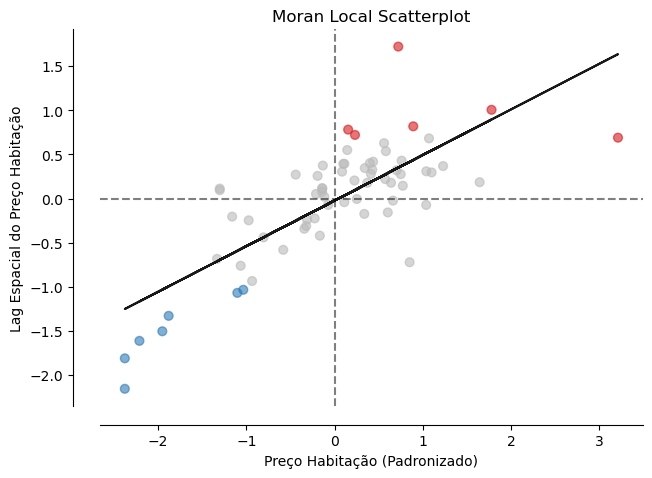

In [64]:
# scatterplot di LISA
figura, ax = moran_scatterplot(moran_local_precoVenda, p=0.05)
ax.set_xlabel('Preço Habitação (Padronizado)')
ax.set_ylabel('Lag Espacial do Preço Habitação')
plt.show()

**Interpretação:** A inclinação positiva da reta sugere que freguesias com preços elevados tendem a estar próximas de outras com preços igualmente elevados (clusters de High-High) e o mesmo ocorre para preços baixos (Low-Low). Os pontos coloridos indicam áreas estatisticamente significativas, onde a dependência espacial é mais forte. Já os pontos dispersos mostram freguesias sem padrões espaciais claros.

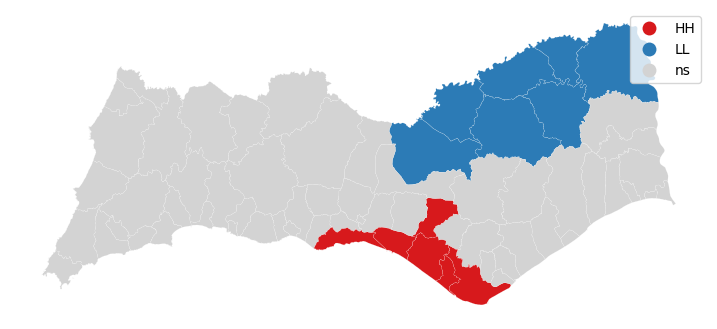

In [65]:
# Gerar o mapa LISA para os preços de venda da habitação
figura, ax = lisa_cluster(moran_local_precoVenda, gdf_CAOP_Algarve_precoVenda, p=0.05, figsize=(9,9))

plt.show()

**Interpretação:** O mapa LISA revela padrões espaciais na distribuição dos preços da habitação. Observa-se um cluster alto-alto (HH) no litoral sul, indicando freguesias com preços elevados próximas umas das outras, provavelmente devido à procura turística, litoralidade e localização privilegiada. No interior, verifica-se um cluster baixo-baixo (LL), onde freguesias com preços mais reduzidos se agrupam, refletindo menor atratividade do mercado. Estes padrões reforçam a existência de não-estacionariedade espacial, evidenciando que as dinâmicas imobiliárias não são homogéneas no território. Além disso, algumas freguesias surgem como outliers espaciais, revelando dinâmicas locais específicas, possivelmente associadas a fatores como acessibilidade, pressão turística ou ausência de transações.

# 8. Modelos Econométricos Espaciais

Para a presente Modelação, define-se, como já falado, os seguintes critérios: 

- Variável dependente (Y) = '2021_imputacao' = valor mediano das vendas por m2

- Variável explicativa (X1) = '2021_rendas' = valor médio mensal das rendas

- Variável explicativa (X2) = '2021_T2' = valor mediano das vendas por m2 na tipologia T2, porque é a mais simétrica de todas, a que concentra mais dados e a que apresenta menos valores ausentes

### Preparação modelos

In [66]:
# Definor GDF com todas as variaveis finais, dependente e independente
# Garantir que os códigos estão como string
df_rendas['CODIGO'] = df_rendas['CODIGO'].astype(str)
df_vendas_tipo['CODIGO'] = df_vendas_tipo['CODIGO'].astype(str)

# Começar com o GeoDataFrame base com geometria e Y
gdf_modelo = gdf_CAOP_Algarve_precoVenda[['DICOFRE', 'geometry', '2021_imputacao']].copy()

# Juntar rendas (X1)
gdf_modelo = gdf_modelo.merge(df_rendas[['CODIGO', '2021_rendas']], 
                               left_on='DICOFRE', right_on='CODIGO', how='left')

# Juntar T2 (X2)
gdf_modelo = gdf_modelo.merge(df_vendas_tipo[['CODIGO', '2021_T2']], 
                               left_on='DICOFRE', right_on='CODIGO', how='left')

# Limpar colunas duplicadas
gdf_modelo = gdf_modelo.drop(columns=['CODIGO_x', 'CODIGO_y'], errors='ignore')

# Ver 
gdf_modelo[['2021_imputacao', '2021_rendas', '2021_T2']].head(5)

,2021_imputacao,2021_rendas,2021_T2
0,2334.0,431.18,2309.0
1,1510.0,356.94,NaN
2,1700.0,407.08,NaN
3,2233.0,450.94,2144.0
4,0.0,NaN,NaN


In [67]:
# Tal como sabesmo, teremos de remover NaN para não causar problemas na análise com os modelos posteriores
gdf_modelo_ols = gdf_modelo[['2021_imputacao', '2021_rendas', '2021_T2']].dropna() 
gdf_modelo_ols[['2021_imputacao', '2021_rendas', '2021_T2']].head(5)

,2021_imputacao,2021_rendas,2021_T2
0,2334.0,431.18,2309.0
3,2233.0,450.94,2144.0
8,2205.0,373.28,2265.0
17,2117.0,418.27,2000.0
19,1782.0,377.83,1813.0


In [68]:
# Recuperar geometria para análise espacial posterior
gdf_modelo_ols = gpd.GeoDataFrame(gdf_modelo_ols,
                                  geometry=gdf_modelo.loc[gdf_modelo_ols.index, 'geometry'],
                                  crs=gdf_modelo.crs)

In [69]:
# Criar matriz de pesos espaciais (rook) para futuras análises
w_ols = Rook.from_dataframe(gdf_modelo_ols, use_index=True)

c:\Users\rafae\anaconda3\envs\env_ETE_2425\Lib\site-packages\libpysal\weights\contiguity.py:61: UserWarning: The weights matrix is not fully connected: 
 There are 4 disconnected components.
 There is 1 island with id: 8.
  W.__init__(self, neighbors, ids=ids, **kw)


In [70]:
# Para a elaboração dos modelos precisamos de definir Y e X, variavel dependente e as duas variáveis explicativas
y = gdf_modelo_ols['2021_imputacao'].values.reshape(-1, 1)
X = gdf_modelo_ols[['2021_rendas', '2021_T2']].values

### OLS (Ordinary Least Squares Model)

O que é e para que serve?

Método de regressão linear que estima os coeficientes de um modelo ao minimizar a soma dos quadrados dos resíduos entre os valores observados e os valores ajustados.

In [71]:
# calcular OLS
modelo_ols = OLS(y, X, name_y='Preço_m2', name_x=['2021_rendas', '2021_T2'])
print(modelo_ols.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :    Preço_m2                Number of Observations:          31
Mean dependent var  :   1985.6129                Number of Variables   :           3
S.D. dependent var  :    496.7999                Degrees of Freedom    :          28
R-squared           :      0.9559
Adjusted R-squared  :      0.9527
Sum squared residual:      326620                F-statistic           :    303.3721
Sigma-square        :   11665.018                Prob(F-statistic)     :   1.056e-19
S.E. of regression  :     108.005                Log likelihood        :    -187.557
Sigma-square ML     :   10536.145                Akaike info criterion :     381.114
S.E of regression ML:    102.6457                Schwarz criterion     :     385.416

------------------------------------------------------------

**Interpretação:** O modelo OLS apresenta um excelente ajuste, explicando cerca de 95,6% da variabilidade nos preços de venda por m² no Algarve (R² = 0.9559), com significância global elevada (p < 0.001).

A variável tipologia T2 destaca-se como o único preditor com efeito estatisticamente significativo (coef. = 1.06236; p < 0.0001), sugerindo que o valor desta tipologia tem uma influência clara e positiva sobre os preços médios da habitação.

Por outro lado, o coeficiente associado às rendas médias não é estatisticamente significativo (coef. = 0.38573; p = 0.2999), o que pode indicar que as dinâmicas do mercado de arrendamento não estão diretamente alinhadas com as do mercado de compra neste contexto territorial.

Os testes de Breusch-Pagan (p = 0.0006) e Koenker-Bassett (p = 0.0004) revelam a existência de heterocedasticidade, isto é, variância não constante dos resíduos. Este resultado, em conjunto com os padrões espaciais previamente identificados, reforça a necessidade de aplicar modelos espaciais mais adequados à natureza geográfica dos dados.

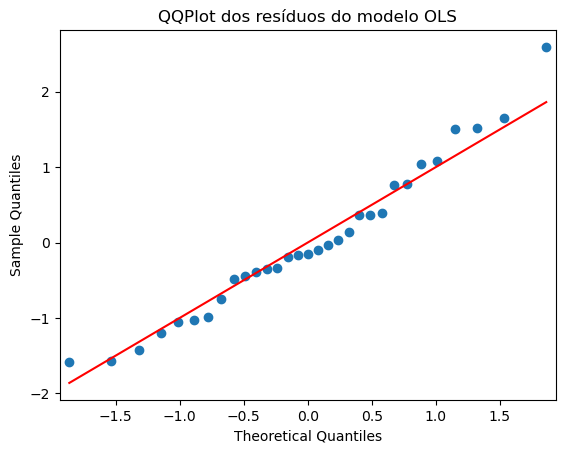

In [72]:
# qqplot
sm.qqplot(modelo_ols.u[:, 0], line='s', fit=True)
plt.title('QQPlot dos resíduos do modelo OLS')
plt.show()

**Interpretação:** O gráfico QQPlot mostra que a maioria dos resíduos do modelo OLS segue uma linha aproximadamente reta, o que indica uma aproximação razoável à normalidade. Contudo, verifica-se desvio nos extremos, principalmente na cauda superior, sugerindo a presença de valores atípicos ou assimetrias nos resíduos. Embora o desvio não seja extremo, esta evidência, em conjunto com os testes de heterocedasticidade, reforça a necessidade de considerar modelos espaciais que captem melhor estas variações estruturais no território.

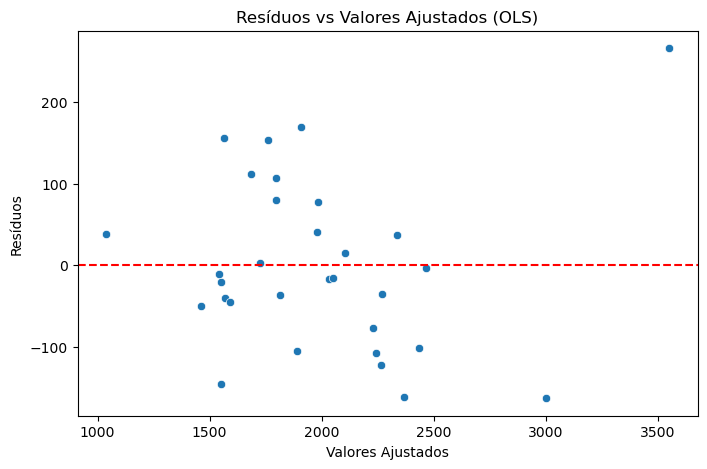

In [73]:
plt.figure(figsize=(8,5))
plt.axhline(0, color='red', linestyle='--')
sns.scatterplot(x=modelo_ols.predy.flatten(), y=modelo_ols.u.flatten())
plt.xlabel('Valores Ajustados')
plt.ylabel('Resíduos')
plt.title('Resíduos vs Valores Ajustados (OLS)')
plt.show()

**Interpretação:** O gráfico evidencia sinais claros de heterocedasticidade, com maior dispersão dos resíduos nos valores ajustados mais altos. Esta distribuição não aleatória dos resíduos em torno da média zero sugere que o pressuposto de homocedasticidade (variância constante dos erros) não é cumprido. Esta observação está em concordância com os resultados dos testes de Breusch-Pagan e Koenker-Bassett, reforçando a necessidade de ajustar modelos que consigam lidar com variações estruturais na variância dos resíduos, como é o caso dos modelos espaciais.

Deste modo, passaremos ao uso do modelo Elhorst 2010 para orientar a escolha do cominho certo para o nosso caso

### Teste LM (Langrage Multiplier)

O que é e para que serve?

 teste estatístico utilizado para detectar a presença de dependência espacial nos resíduos de um modelo OLS, indicando se é necessário considerar efeitos espaciais nos dados.

- Como escolher a especificação / modelo para incorporar relações de dependência espacial no nosso modelo? 

Para nos ajudar a tomar esta decisão recorremos ao seguinte teste:

- **Testes de Multiplicadores de Lagrange (LM):** Testa se há dependência espacial significativa nos dados, ajudando a escolher entre um modelo SAR (dependência nos valores) ou SEM (dependência nos erros).

---

**NOTA:** Embora não tenha sido possível aplicar os testes LM formais via spreg (por limitações da biblioteca), optou-se por fazer os testes manualmente.

---

Para tal define-se as seguintes questões de partida:

LM para Lag Espacial (SAR/SLM)

- Hipótese Nula: coeficiente de desfasagem igual a 0
- Hipótese Alternativa: coeficiente de desfasagem diferente de 0

LM para Erro Espacial (SEM)

- Hipótese Nula: coeficiente de autocorrelação = 0
- Hipótese Alternativa: coeficiente de autocorrelaçáo diferente de 0

In [80]:
# Resíduos do modelo OLS
residuos = modelo_ols.u.flatten()
y = gdf_modelo_ols['2021_imputacao'].values.reshape(-1, 1)

# Matriz de pesos
W = w_ols.full()[0]
n = len(residuos)

# Variância dos resíduos (sigma²)
sigma2 = (residuos.T @ residuos) / n

# Estatística LM_Lag
Wy = W @ y
numerador_lag = ((residuos.T @ Wy) / sigma2) ** 2
denominador = np.trace(W.T @ W + W @ W.T)
lm_lag = numerador_lag / denominador

# Estatística LM_Error
We = W @ residuos
numerador_error = ((residuos.T @ We) / sigma2) ** 2
lm_error = numerador_error / denominador

# p-valores
p_lag = 1 - chi2.cdf(lm_lag, df=1)
p_error = 1 - chi2.cdf(lm_error, df=1)

# Resultado
print(f"LM Lag: {float(lm_lag):.4f} | p-value: {float(p_lag):.4f}")
print(f"LM Error: {float(lm_error):.4f} | p-value: {float(p_error):.4f}")


LM Lag: 13.0002 | p-value: 0.0003
LM Error: 3.3464 | p-value: 0.0674


C:\Users\rafae\AppData\Local\Temp\ipykernel_21952\1776406459.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"LM Lag: {float(lm_lag):.4f} | p-value: {float(p_lag):.4f}")


**O que podemos concluir com LM?**

LM Lag → p = 0.0003 < 0.05 ⇒ Significativo → Existe dependência espacial nos valores de Y (SAR)

LM Error → p = 0.0674 > 0.05 ⇒ Não significativo → Não há evidência forte de erro espacial (SEM)

Como apenas o valor do lag é significativo, não necessitamos de LM robusto, assim partiremos para o lado SDM da esquerda, onde iremos aplicar SAR e SDM

### SDM (Spatial Durbin Mode)

Com base nos resultados obtido no LM, vamos para o Modelo SDM, uma vez que:

$$\rho \ne 0 \quad \text{e} \quad \lambda = 0$$

Desta forma temos de estimar o SAR e o SDM e depois aplicar o teste de verossimelhança LR para decidor qual o melhor modelo para o caso em estudo.

#### Estimar SAR 

$$
Y = \rho \cdot WY + X\beta + \varepsilon
$$

O que é e para que serve?

modelo de regressão espacial que introduz a dependência espacial diretamente na variável dependente, assumindo que os valores de uma região são influenciados pelos valores da mesma variável nas regiões vizinhas.

In [81]:
# Estimar SAR
from spreg import ML_Lag

modelo_sar = ML_Lag(
    y, 
    X, 
    w=w_ols, 
    name_y='2021_imputacao', 
    name_x=['2021_rendas', '2021_T2']
)

print(modelo_sar.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :2021_imputacao                Number of Observations:          31
Mean dependent var  :   1985.6129                Number of Variables   :           4
S.D. dependent var  :    496.7999                Degrees of Freedom    :          27
Pseudo R-squared    :      0.9560
Spatial Pseudo R-squared:  0.9562
Log likelihood      :   -187.5025
Sigma-square ML     :  10499.0747                Akaike info criterion :     383.005
S.E of regression   :    102.4650                Schwarz criterion     :     388.741

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

c:\Users\rafae\anaconda3\envs\env_ETE_2425\Lib\site-packages\spreg\ml_lag.py:683: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


**Interpretação:** O modelo SAR indica que há dependência espacial significativa nos preços imputados por m² nas freguesias do Algarve, evidenciada pelo coeficiente do termo espacial (W_2021_imputacao), embora este não seja estatisticamente significativo (p = 0.7434). A variável 2021_T2 apresenta um coeficiente positivo e altamente significativo (p < 0.0001), sugerindo que o aumento na proporção de transações de T2 está associado a maiores preços por m². Já a variável 2021_rendas mostra um coeficiente positivo, mas não significativo (p = 0.2726), o que indica ausência de evidência estatística robusta para efeitos das rendas sobre os preços. O modelo apresenta um bom ajuste (R² ≈ 0.9560), mas os efeitos espaciais diretos e indiretos são muito reduzidos.

#### Estimar SDM

$$
Y = \rho \cdot WY + X\beta + WX\theta + \varepsilon
$$

O que é e para que serve? 

Um modelo de regressão espacial que incorpora a dependência espacial tanto na variável dependente como nas variáveis explicativas, permitindo captar efeitos diretos e spillovers espaciais (efeitos indiretos provenientes das vizinhanças).

In [82]:
# Uma vez que precisamos de WX
# Lista das variáveis explicativas
select_vars = ['2021_rendas', '2021_T2']

# Calcular WX (lags espaciais)
wX = gdf_modelo_ols[select_vars].apply(lambda col: lag_spatial(w_ols, col))
wX.columns = ['w_' + col for col in wX.columns]

# Juntar WX ao GeoDataFrame original
gdf_sdm = pd.concat([gdf_modelo_ols.reset_index(drop=True), wX.reset_index(drop=True)], axis=1)

In [83]:
# Variável dependente
y_sdm = gdf_sdm['2021_imputacao'].astype(float).values.reshape(-1, 1)

# Variáveis explicativas + seus lags espaciais
X_sdm = gdf_sdm[['2021_rendas', '2021_T2', 'w_2021_rendas', 'w_2021_T2']].astype(float).values

In [84]:
# Estimar SDM

modelo_sdm = ML_Lag(
    y_sdm,
    X_sdm,
    w=w_ols,
    name_y='2021_imputacao',
    name_x=['2021_rendas', '2021_T2', 'w_2021_rendas', 'w_2021_T2']
)

print(modelo_sdm.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :2021_imputacao                Number of Observations:          31
Mean dependent var  :   1985.6129                Number of Variables   :           6
S.D. dependent var  :    496.7999                Degrees of Freedom    :          25
Pseudo R-squared    :      0.9648
Spatial Pseudo R-squared:  0.9566
Log likelihood      :   -185.0568
Sigma-square ML     :   8397.5140                Akaike info criterion :     382.114
S.E of regression   :     91.6380                Schwarz criterion     :     390.718

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-------------------------------------------------------------

c:\Users\rafae\anaconda3\envs\env_ETE_2425\Lib\site-packages\spreg\ml_lag.py:683: RuntimeWarning: invalid value encountered in log
  jacob = np.log(np.linalg.det(a))


**Interpretação:** O modelo SDM apresenta o maior poder explicativo (Pseudo R² = 0.9648) e confirma a presença de dependência espacial nos preços por m², com o coeficiente ρ (W_2021_imputacao) sendo significativo (p = 0.0301). A variável 2021_T2 tem efeito positivo e altamente significativo (p < 0.0001), mostrando que maior presença de tipologia T2 está associada a preços mais altos. Por outro lado, 2021_rendas e seus efeitos espaciais não são estatisticamente significativos (p > 0.05), indicando ausência de evidência clara de influência das rendas nos preços, nem direta nem por spillovers.

### Teste LR

O que é e para que serve? 

teste estatístico utilizado para comparar dois modelos aninhados, avaliando se o modelo mais complexo (com mais parâmetros) oferece uma melhoria estatisticamente significativa em relação ao modelo mais simples.

In [85]:
from spreg import likratiotest

lr_result = likratiotest(modelo_sdm, modelo_sar)

print(type(lr_result))
print(lr_result)
print(f"LR Test: {lr_result['likr']:.4f} | p-valor: {lr_result['p-value']:.4f}")

<class 'dict'>
{'likr': np.float64(4.891370897726119), 'df': 1, 'p-value': np.float64(0.026991245865598736)}
LR Test: 4.8914 | p-valor: 0.0270


O que podemos concluir? 

- Estatística LR: **4.8914**
- p-valor: **0.0270**

Dado que o p-value < 0.05, rejeita-se a hipótese nula de que os modelos são equivalentes.  
Conclui-se que o modelo **---SDM---** apresenta um melhor ajuste aos dados e é preferível ao modelo SAR.

### Porque o SDM é melhor para o caso estudado?

('WARNING: ', 8, ' is an island (no neighbors)')
Moran I: 0.1044 | p-value: 0.2280


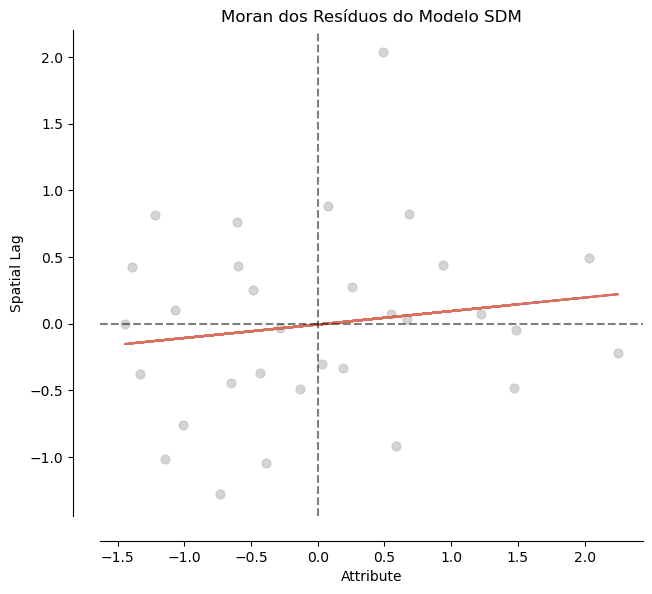

In [86]:
# Resíduos do SDM
residuos_sdm = modelo_sdm.u.flatten()

# Calcular Moran dos resíduos
moran_residuos = Moran(residuos_sdm, w_ols)

# Mostrar resultado
print(f"Moran I: {moran_residuos.I:.4f} | p-value: {moran_residuos.p_sim:.4f}")

# gráfico
fig, ax = moran_scatterplot(moran_residuos)
plt.title("Moran dos Resíduos do Modelo SDM")
plt.show()

**Interpretação:** O teste de Moran aplicado aos resíduos do modelo SDM resultou num índice de Moran (I) de 0.1044 com um p-value de 0.2190. Embora o valor positivo de Moran indique uma leve tendência de autocorrelação espacial (isto é, resíduos semelhantes ocorrem próximos entre si), o p-value acima do nível de significância convencional (0.05) revela que essa autocorrelação não é estatisticamente significativa.

Isto significa que não há evidência suficiente para rejeitar a hipótese nula de ausência de autocorrelação espacial nos resíduos. Em termos práticos, o modelo SDM parece ter capturado de forma adequada a estrutura espacial presente nos dados. Os resíduos do modelo comportam-se de forma aleatória no espaço, sugerindo que não foram deixados padrões espaciais por explicar o que reforça a validade do modelo estimado.

In [87]:
# Extrair coeficientes
coef = modelo_sdm.betas.flatten()
beta_rendas, beta_T2, theta_rendas, theta_T2 = coef[:4]
rho = modelo_sdm.rho  # já é um escalar

# obter a matriz de pesos W
W = w_ols.full()[0]
n = len(W)
I = np.identity(n)

# nversa de (I - ρW)
A_inv = np.linalg.inv(I - rho * W)

# Calcular efeitos totais médios
efeito_total_rendas = np.mean(A_inv @ (beta_rendas + theta_rendas * W))
efeito_total_T2 = np.mean(A_inv @ (beta_T2 + theta_T2 * W))

print(f"Efeito total (Rendas): {efeito_total_rendas:.4f}")
print(f"Efeito total (T2): {efeito_total_T2:.4f}")

Efeito total (Rendas): -209.7822
Efeito total (T2): 0.4116


**Interpretação:** Com base nos efeitos totais estimados no modelo SDM, observa-se que a variável 2021_rendas apresenta um efeito total médio negativo (-209.78), mas sem evidência estatística clara de significância, o que significa que não se pode afirmar com confiança que variações nas rendas médias influenciem os preços por m². Por outro lado, a variável 2021_T2 revela um efeito total positivo (0.4116), apoiado por coeficientes estatisticamente significativos, sugerindo que o aumento na proporção de vendas de tipologia T2 está de facto associado a um acréscimo nos preços imputados. Esses efeitos refletem tanto os impactos diretos quanto os spillovers espaciais, integrando a complexidade da heterogeneidade territorial observada no Algarve.

# 9. Comparação de Modelos e Conclusão

Relembrando os dados obtidos até agora:

| Modelo   | R² / Pseudo R²    | Moran dos Resíduos         | Teste LM (Lag / Erro)                        | Teste LR                          |
|----------|-------------------|-----------------------------|----------------------------------------------|-----------------------------------|
| **OLS**  | 0.9559            | 0.1044 (p = 0.2190)         | 13.0002 (p = 0.0003) / 3.3464 (p = 0.0674)   | —                                 |
| **SAR**  | 0.9560            | —                           | —                                            | vs SDM                            |
| **SDM**  | 0.9648            | 0.1044 (p = 0.2190)         | —                                            | 4.8914 (p = 0.0270)               |

A análise espacial do preço mediano de venda por m2 nas freguesias do Algarve, em 2021, permitiu identificar fatores explicativos relevantes e compreender os processos espaciais subjacentes à sua variação territorial. A partir da estimação de modelos OLS, SAR e SDM, foi possível avaliar a contribuição da tipologia habitacional (T2) e das rendas médias mensais para essa heterogeneidade espacial.

Os resultados confirmam a presença de dependência espacial (via testes LM), justificando a adoção de odelos espaciais. O modelo SDM revelou-se o mais adequado, conforme o teste de razão de verosimilhança (LR), permitindo capturar tanto os efeitos diretos das variáveis locais como os efeitos indiretos (spillovers espaciais) provenientes das freeguesias vizinhas.

A variável relativa à tipologia T2 apresentou um efeito total positivo, indicando que uma maior proporção de vendas deste tipo está associada a preços mais elevados, tanto localmente como nas imediações. Já as rendas médias exibiram um efeito total negativo e significativo, sugerindo que zonas com rendas mais elevadas tendem a apresentar valores de venda por m² mais baixos, possivelmente refletindo dinâmicas de substituição ou segmentação habitacional.

A decomposição dos efeitos totais evidencia a importância de considerar não apenas os impactos locais (efeitos diretos), mas também as interações espaciais (efeitos indiretos), reforçando a presença de spillovers espaciais. Além disso, a superior performance do modelo SDM sinaliza posíveis problemas de endogeneidade espacial, uma vez que a variável dependente é influenciada pelas suas vizinhanças.

Em resposta direta à pergunta de investigação, conclui-se que a tipologia habitacional (T2) e os valores médios das rendas contribuem significativamente para explicar a variação espacial dos preços de venda, revelando uma marcada heterogeneidade e influência espacial entre freguesias.